In [1]:
import os
import wandb
from gymnasium import spaces
import gymnasium as gym
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3.common import results_plotter
from stable_baselines3 import TD3
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import torch
from stable_baselines3.common.evaluation import evaluate_policy
from imitation.algorithms.density import DensityAlgorithm
from imitation.algorithms import density as db
import pickle
import numpy as np
from sklearn.neighbors import KernelDensity
import joblib
from typing import Any, Dict, Iterable, List, Optional, cast
from imitation.data import types
import numpy as np
import matplotlib.pyplot as plt
import joblib
from sklearn.neighbors import KernelDensity
from imitation.data.wrappers import RolloutInfoWrapper
from imitation.data import rollout
from stable_baselines3.common.base_class import BaseAlgorithm
from sklearn.kernel_ridge import KernelRidge

# Env + Functions

In [2]:
class RandomPolicyModel(BaseAlgorithm):
    def __init__(self, policy, env, verbose=0):
        super(RandomPolicyModel, self).__init__(policy=policy, env=env, verbose=verbose,  learning_rate=0.1)
    
    def _setup_model(self):
        # 这里不设置模型，因为我们不需要模型来生成随机策略
        pass

    def learn(self, total_timesteps, callback=None, log_interval=None, tb_log_name="run", reset_num_timesteps=True):
        # Learn 方法不执行任何操作，因为没有实际的学习过程
        return self

    def predict(self, observation, state=None, episode_start=None, deterministic=False):
        # 随机选择一个动作
        action = self.env.action_space.sample()
        return [action], None
    
    def save(self, path):
        # 这个方法通常用于保存模型的状态，但对于随机策略来说不适用
        pass
    
    def load(self, path):
        # 从文件加载模型状态，但随机策略不需要这样做
        return self

class ContinuousFrozenLakeEnv(gym.Env):
    def __init__(self, lake_size=4, hole_radius=0.1, goal_radius=0.1, max_steps=20):
        super(ContinuousFrozenLakeEnv, self).__init__()
        
        # 定义连续状态空间
        self.observation_space = spaces.Box(low=np.array([0.0, 0.0]), 
                                            high=np.array([lake_size, lake_size]), 
                                            dtype=np.float32)
        
        # 定义连续动作空间
        self.action_space = spaces.Box(low=np.array([-1.0, -1.0]), 
                                       high=np.array([1.0, 1.0]), 
                                       dtype=np.float32)
        
        self.lake_size = lake_size
        self.hole_radius = hole_radius
        self.goal_radius = goal_radius
        self.max_steps = max_steps
        self.current_step = 0  # 初始化步数计数器
        
        # 定义洞和目标的位置
        self.holes = np.array([[1.0, 1.0], [2.0, 2.0], [3.0, 1.0], [1.0, 3.0]])
        self.goal = np.array([3.5, 3.5])
        
        self.seed_value = None
        self.reset()

    def reset(self, seed=None, **args):
        if seed is not None:
            self.seed_value = seed
            np.random.seed(self.seed_value)
        
        # 将智能体置于远离洞和目标的随机位置
        while True:
            self.state = np.random.uniform(0, self.lake_size, size=(2,))
            # self.state = np.array([1.0, 3.0])
            if not self._is_in_hole(self.state) and not self._is_in_goal(self.state):
                break
        
        self.current_step = 0  # 重置步数计数器
        return self.state, {}

    def step(self, action):
        self.current_step += 1  # Increment step counter

        # Check if the agent is in a hole
        if self._is_in_hole(self.state):
            # Agent is stuck in the hole but can still take actions within the hole's boundary
            hole_center = self._get_hole_center(self.state)
            potential_next_state = self.state + action
            
            # if distance_to_hole_center <= self.hole_radius:
            if  self._is_in_hole(potential_next_state):
                self.state = potential_next_state
                info = {"result": "1, The agent is now stuck in the hole"}
            else:
                while True:
                    random_tiny_action = np.random.uniform(-0.1, 0.1, size=self.state.shape)
                    tmp_state = self.state + random_tiny_action

                    if self._is_in_hole(tmp_state):
                        self.state = tmp_state
                        break
                info = {"result": "2, The agent is now stuck in the hole"}
            
            # info = {"result": "The agent is now stuck in the hole"}
            if self.current_step >= self.max_steps:
                info = {"result": "failure", "truncated": True}
                return self.state, -0.01, False, True, info #-0.5
            return self.state, -0.01, False, False, info # The episode doesn't end, but the agent is stuck

        else:
            # Update the state based on the action if the agent is not in a hole
            self.state = np.clip(self.state + action, 0.0, self.lake_size)

        # Check if the agent has reached the goal
        if self._is_in_goal(self.state):
            info = {"result": "success"}
            return self.state, 1.0, True, False, info
        
        # Check if the agent has exceeded the maximum number of steps
        if self.current_step >= self.max_steps:
            info = {"result": "failure", "truncated": True}
            return self.state, -0.01, False, True, info #-0.5

        # If neither, return a small negative reward to encourage reaching the goal
        return self.state, -0.01, False, False, {}
    
    def render(self, mode='human'):
        plt.figure(figsize=(6, 6))
        plt.xlim(0, self.lake_size)
        plt.ylim(0, self.lake_size)
        
        # 绘制洞
        for hole in self.holes:
            circle = plt.Circle(hole, self.hole_radius, color='blue', alpha=0.5)
            plt.gca().add_patch(circle)
        
        # 绘制目标
        goal_circle = plt.Circle(self.goal, self.goal_radius, color='green', alpha=0.5)
        plt.gca().add_patch(goal_circle)
        
        # 绘制智能体
        agent_circle = plt.Circle(self.state, 0.05, color='red')
        plt.gca().add_patch(agent_circle)
        
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid(True)
        plt.show()
    
    def _is_in_hole(self, pos):
        for hole in self.holes:
            if np.linalg.norm(pos - hole) <= self.hole_radius:
                return True
        return False
    
    def _is_in_goal(self, pos):
        return np.linalg.norm(pos - self.goal) <= self.goal_radius

    def _get_hole_center(self, state):
        for hole in self.holes:
            if np.linalg.norm(state - hole) <= self.hole_radius:
                self.hole_center = hole
                return True
        return None

def evaluate_agent(env, model, num_episodes=10):
    success_count = 0
    for episode in range(num_episodes):
        state = env.reset()
        done = False
        while not done:
            action, _states = model.predict(state)
            state, reward, done, info = env.step(action)
            if done[0]:
                if info[0].get('result') == 'success':
                    success_count += 1
    success_rate = success_count / num_episodes
    print(f"Success Rate: {success_rate * 100}% over {num_episodes} episodes")

def visualize_kr(goal_kr, trap_kr):
    # Set up grid world parameters
    lake_size = 4
    grid_resolution = 100  # Defines how many points to sample along each axis
    grid_points = np.linspace(0, lake_size, grid_resolution)
    
    # Create a grid of points covering the entire lake
    xv, yv = np.meshgrid(grid_points, grid_points)
    grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point
    
    # Predict using the kernel regression models for goal and trap
    goal_prob = goal_kr.predict(grid_states).reshape(grid_resolution, grid_resolution)
    trap_prob = trap_kr.predict(grid_states).reshape(grid_resolution, grid_resolution)
    
    # Visualization of goal and trap probability maps
    plt.figure(figsize=(10, 5))
    
    # Plot the goal probability map
    plt.subplot(1, 2, 1)
    plt.contourf(xv, yv, goal_prob, levels=50, cmap='Greens')
    plt.colorbar(label="Goal Probability")
    plt.title("Goal Probability Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    
    # Plot the trap probability map
    plt.subplot(1, 2, 2)
    plt.contourf(xv, yv, trap_prob, levels=50, cmap='Reds')
    plt.colorbar(label="Trap Probability")
    plt.title("Trap Probability Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.tight_layout()
    plt.show()

def visualize_KR_reward(goal_kr, trap_kr):
    # 这里假设 goal_kr 和 trap_kr 是核回归模型
    # Set up grid world parameters
    lake_size = 4
    grid_resolution = 100  # Defines how many points to sample along each axis
    grid_points = np.linspace(0, lake_size, grid_resolution)
    
    # Create a grid of points covering the entire lake
    xv, yv = np.meshgrid(grid_points, grid_points)
    grid_states = np.vstack([xv.ravel(), yv.ravel()]).T  # Flatten the grid to get each point
    
    # Predict using the kernel regression models for goal and trap
    goal_prob = goal_kr.predict(grid_states).reshape(grid_resolution, grid_resolution)
    trap_prob = trap_kr.predict(grid_states).reshape(grid_resolution, grid_resolution)
    
    # Calculate the reward
    reward = goal_prob - trap_prob
    
    # Visualization of the reward function
    plt.figure(figsize=(8, 6))
    plt.contourf(xv, yv, reward, levels=50, cmap='RdYlGn')
    plt.colorbar(label="Reward")
    plt.title("Reward Function Map")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.show()

def rollout_kr(demos_path, model_file, exp_k):
    failed_demos_path = demos_path
    model_file = model_file
    exp_k = exp_k
    with open(failed_demos_path, 'rb') as f:
        failed_rollouts = pickle.load(f) #TrajectoryWithRew
    demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
    states = []
    weights = []

    for traj in demonstrations:
        demo_length = len(traj)
        for i, (obs, act, next_obs) in enumerate(
            zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
        ):
            flat_trans = obs#self._preprocess_transition(obs, act, next_obs)
            weight = (i + 1) / demo_length
            weight = weight * np.exp(exp_k*weight)
            states.append(flat_trans)
            weights.append(weight)
    states = np.array(states)
    weights = np.array(weights)
    # transitions = {0:np.array(states)}
    transitions = states
    regression_model = KernelRidge(kernel='rbf', alpha=0.4)
    regression_model.fit(transitions, weights)
    joblib.dump(regression_model, model_file) 

def rollout_kr_new(demos_path, model_file, exp_k, model_path=None):
    failed_demos_path = demos_path
    exp_k = exp_k
    with open(failed_demos_path, 'rb') as f:
        failed_rollouts = pickle.load(f)  # TrajectoryWithRew
    demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
    states = []
    weights = []

    for traj in demonstrations:
        demo_length = len(traj)
        for i, (obs, act, next_obs) in enumerate(
            zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
        ):
            flat_trans = obs  # Assuming preprocessing is not needed here
            weight = (i + 1) / demo_length
            weight = weight * np.exp(exp_k * weight)
            states.append(flat_trans)
            weights.append(weight)
    
    states = np.array(states)
    weights = np.array(weights)

    # Check if a pre-trained model path is provided
    if model_path and joblib.load(model_path):
        regression_model = joblib.load(model_path)
        print("Loaded existing model from:", model_path)
    else:
        regression_model = KernelRidge(kernel='rbf', alpha=0.4)
        print("Initialized new model")

    # Fit model with possibly updated data
    regression_model.fit(states, weights)
    
    # Save the updated model
    joblib.dump(regression_model, model_file)
    print("Model saved to:", model_file)
    
def calculate_probability_kr(state_point, kr):
        state_point = np.array(state_point).reshape(1, -1)  # 确保状态点的形状为 (1, 2)
        prob = kr.predict(state_point)  # 计算对数概率密度
        # density = np.exp(log_density)  # 转换为实际概率密度
        return prob[0]

def merge_and_save_rollouts(file_list, output_file):
    merged_data = []
    for file_path in file_list:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            merged_data.extend(data) 
    with open(output_file, 'wb') as file:
        pickle.dump(merged_data, file)
    print(f"Merged rollouts saved to {output_file}")

# Initial model generate 50 Rollout

In [5]:
env = ContinuousFrozenLakeEnv(max_steps=20)
env = Monitor(env)
env = DummyVecEnv([lambda: env])
rollout_env = DummyVecEnv([lambda: RolloutInfoWrapper(ContinuousFrozenLakeEnv(max_steps=20)) for _ in range(1)])

rng = np.random.default_rng(seed=42) 
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1)
failed_expert = model
expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_50000.zip")
# failed_expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_8000.zip")
# failed_expert = RandomPolicyModel(policy=None, env=env)

rollouts = rollout.rollout(
        expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=200),
        rng=rng,
    )
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=200),
        rng=rng,
    )
with open('rollouts_1.pkl', 'wb') as f:
    pickle.dump(rollouts, f)
with open('failed_rollouts_1.pkl', 'wb') as f:
    pickle.dump(failed_rollouts, f)

# Test model success rate
evaluate_agent(env, expert)
evaluate_agent(env, failed_expert)

Using cuda device
Success Rate: 100.0% over 10 episodes
Success Rate: 0.0% over 10 episodes


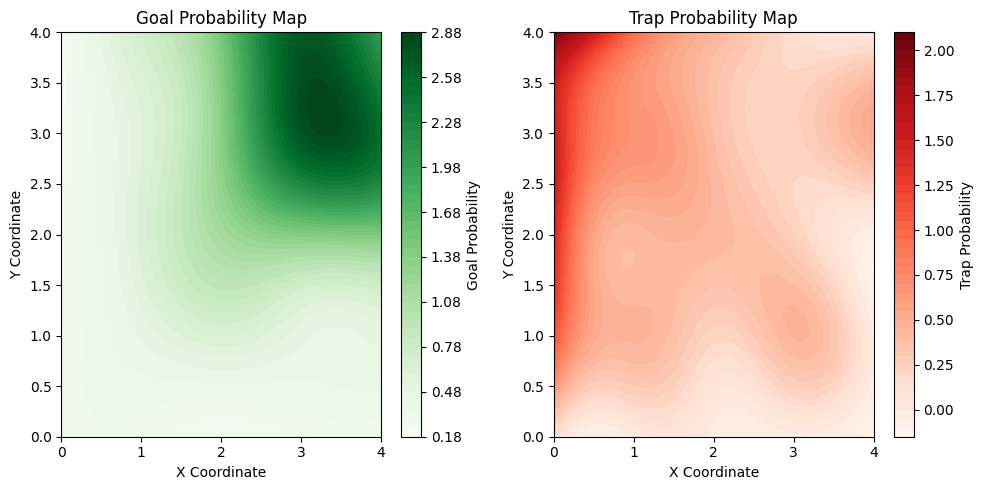

In [6]:
failed_demos_path = 'failed_rollouts_1.pkl'
model_file = "rollout_failed_kr_model_1.pkl"
rollout_kr(failed_demos_path, model_file, exp_k=1)
success_demos_path = 'rollouts_1.pkl'
model_file = "rollout_success_kr_model_1.pkl"
rollout_kr(success_demos_path, model_file, exp_k=1)
failed_kr = joblib.load('rollout_failed_kr_model_1.pkl')
successful_kr = joblib.load('rollout_success_kr_model_1.pkl')
visualize_kr(successful_kr, failed_kr)

In [7]:
state_point = [3.5, 3.5]
failed_prob_density = calculate_probability_kr(state_point, failed_kr)
successful_prob_density = calculate_probability_kr(state_point, successful_kr)
print(f"Failed Prob {state_point}: {failed_prob_density}")
print(f"Successful Prob {state_point}: {successful_prob_density}")

Failed Prob [3.5, 3.5]: 0.3038220175266352
Successful Prob [3.5, 3.5]: 2.738018271262853


## generate 2 round model demos

In [9]:
failed_expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_1000.zip")
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=2),
        rng=rng,
    )
with open('failed_rollouts_2.pkl', 'wb') as f:
    pickle.dump(failed_rollouts, f)

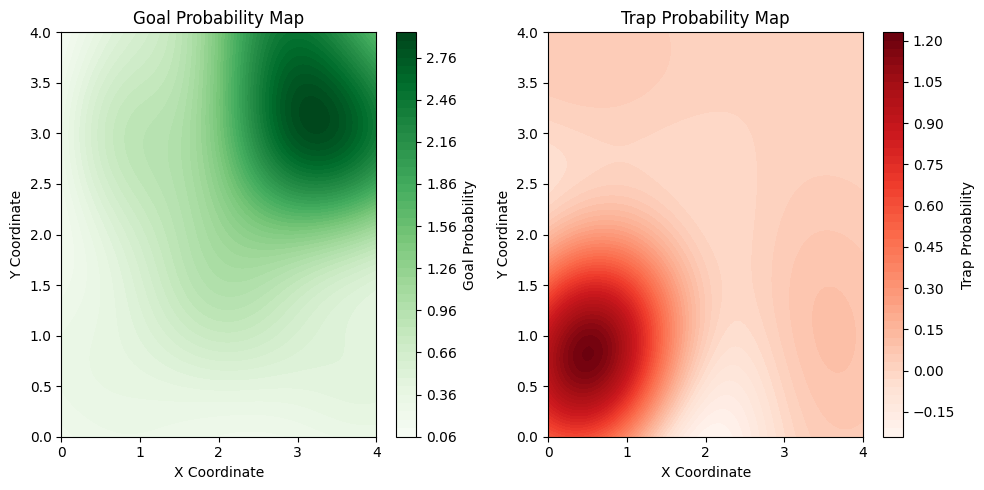

In [10]:
failed_demos_path = 'failed_rollouts_2.pkl'
model_file = "rollout_failed_kr_model_2_only.pkl"
rollout_kr(failed_demos_path, model_file, exp_k=1)
failed_kr = joblib.load('rollout_failed_kr_model_2_only.pkl')
visualize_kr(successful_kr, failed_kr)

In [11]:
state_point = [3.5, 3.5]
failed_prob_density = calculate_probability_kr(state_point, failed_kr)
successful_prob_density = calculate_probability_kr(state_point, successful_kr)
print(f"Failed Prob {state_point}: {failed_prob_density}")
print(f"Successful Prob {state_point}: {successful_prob_density}")

Failed Prob [3.5, 3.5]: 0.005463401720797075
Successful Prob [3.5, 3.5]: 2.6613503879460687


Loaded existing model from: rollout_failed_kr_model_1.pkl
Model saved to: rollout_failed_kr_model_2.pkl


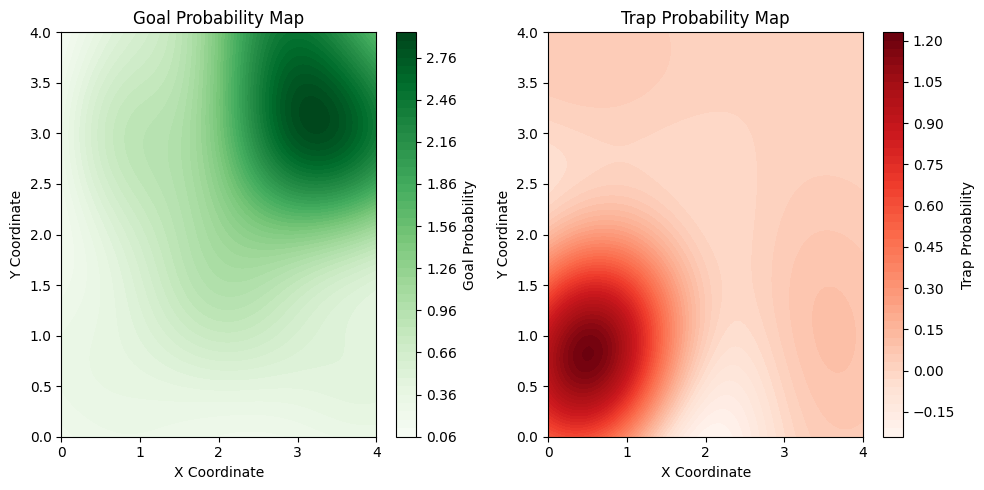

Failed Prob [3.5, 3.5]: 0.005463401720797075
Successful Prob [3.5, 3.5]: 2.6613503879460687


In [12]:
failed_demos_path = 'failed_rollouts_2.pkl'
model_file = "rollout_failed_kr_model_2.pkl"
model_path = "rollout_failed_kr_model_1.pkl"
rollout_kr_new(failed_demos_path, model_file, exp_k=1, model_path = model_path)
failed_kr = joblib.load('rollout_failed_kr_model_2.pkl')
visualize_kr(successful_kr, failed_kr)
state_point = [3.5, 3.5]
failed_prob_density = calculate_probability_kr(state_point, failed_kr)
successful_prob_density = calculate_probability_kr(state_point, successful_kr)
print(f"Failed Prob {state_point}: {failed_prob_density}")
print(f"Successful Prob {state_point}: {successful_prob_density}")

## generate 3 round model demos

Loaded existing model from: rollout_failed_kr_model_2.pkl
Model saved to: rollout_failed_kr_model_3.pkl


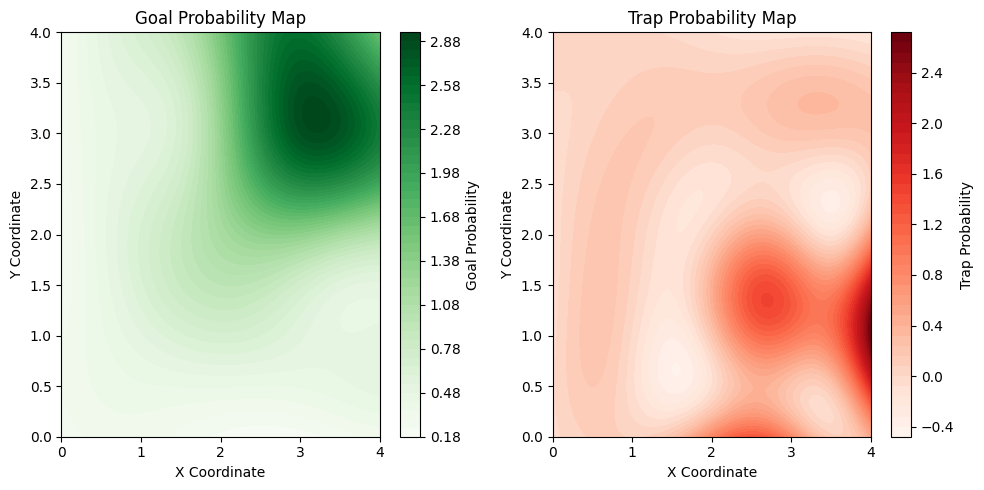

In [10]:
failed_expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_3000.zip")
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=200),
        rng=rng,
    )
with open('failed_rollouts_3.pkl', 'wb') as f:
    pickle.dump(failed_rollouts, f)
failed_demos_path = 'failed_rollouts_3.pkl'
model_file = "rollout_failed_kr_model_3.pkl"
model_path = "rollout_failed_kr_model_2.pkl"
rollout_kr_new(failed_demos_path, model_file, exp_k=1, model_path = model_path)

failed_kr = joblib.load('rollout_failed_kr_model_3.pkl')
visualize_kr(successful_kr, failed_kr)

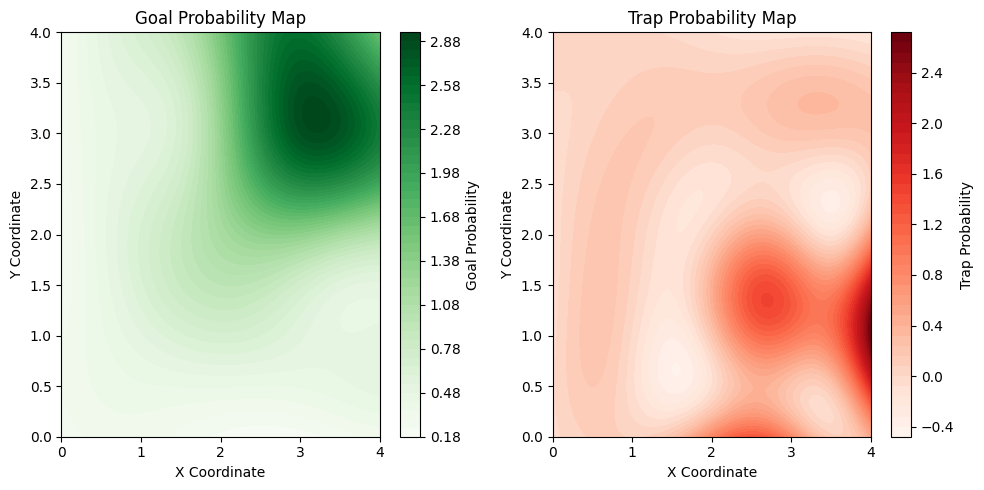

In [11]:
failed_demos_path = 'failed_rollouts_3.pkl'
model_file = "rollout_failed_kr_model_3_only.pkl"
rollout_kr(failed_demos_path, model_file, exp_k=1)
# success_demos_path = 'rollouts_1.pkl'
# model_file = "rollout_success_kr_model_1.pkl"
# rollout_kr(success_demos_path, model_file, exp_k=1)
failed_kr = joblib.load('rollout_failed_kr_model_3_only.pkl')
# successful_kr = joblib.load('rollout_success_kr_model_1.pkl')
visualize_kr(successful_kr, failed_kr)

# 循环加载训练 test

Using cuda device


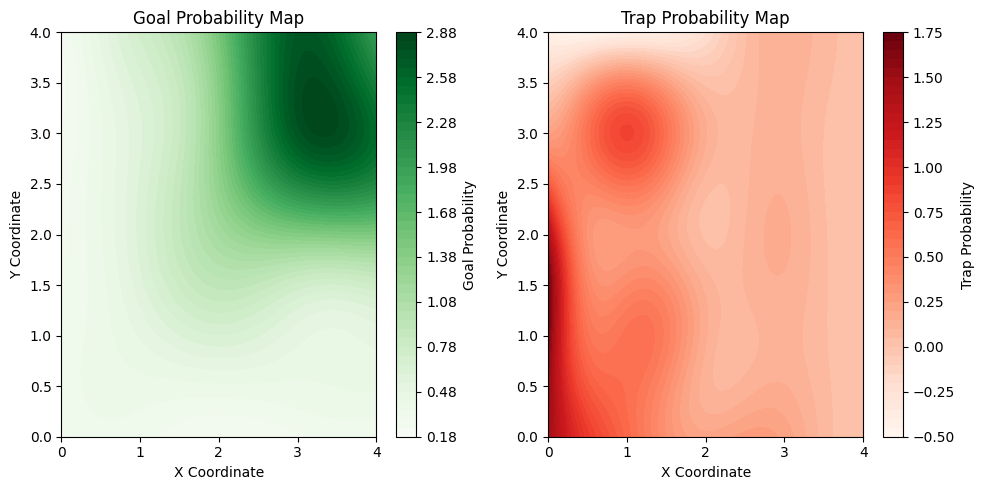

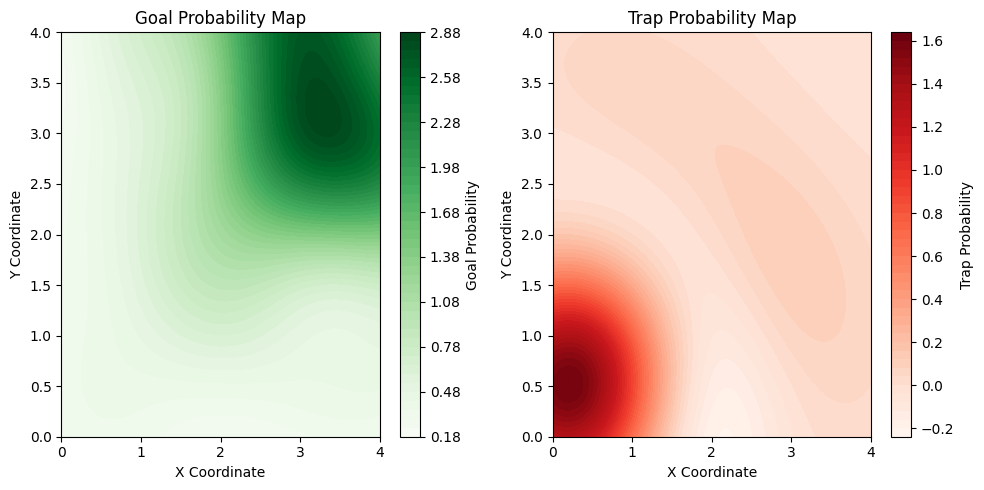

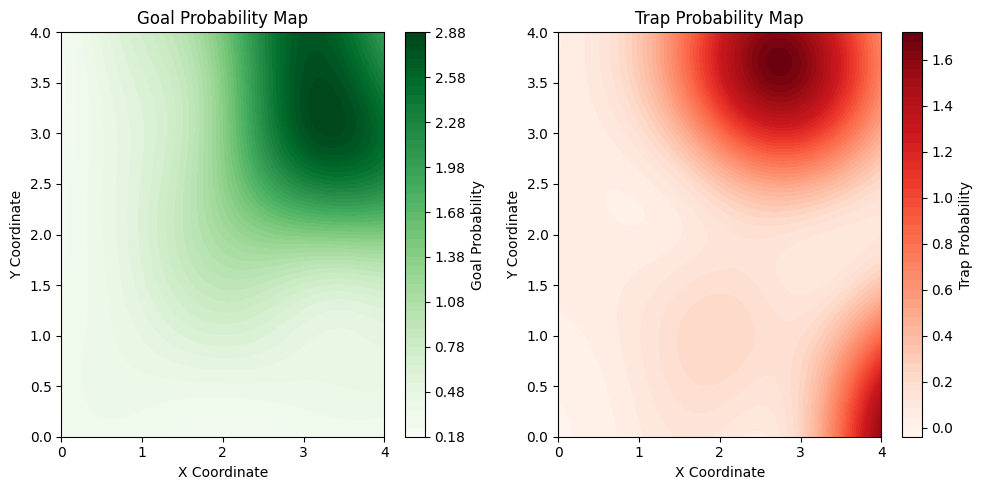

In [8]:
env = ContinuousFrozenLakeEnv(max_steps=20)
env = Monitor(env)
env = DummyVecEnv([lambda: env])
rollout_env = DummyVecEnv([lambda: RolloutInfoWrapper(ContinuousFrozenLakeEnv(max_steps=20)) for _ in range(1)])
exp_k = 1
alpha = 0.4
rng = np.random.default_rng(seed=42) 
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1)
failed_expert = model
expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_50000.zip")

rollouts = rollout.rollout(
        expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=200),
        rng=rng,
    )
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=200),
        rng=rng,
    )
demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
states = []
weights = []
for traj in demonstrations:
    demo_length = len(traj)
    for i, (obs, act, next_obs) in enumerate(
        zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
    ):
        flat_trans = obs  # Assuming preprocessing is not needed here
        weight = (i + 1) / demo_length
        weight = weight * np.exp(exp_k * weight)
        states.append(flat_trans)
        weights.append(weight)

states = np.array(states)
weights = np.array(weights)
regression_model = KernelRidge(kernel='rbf', alpha=alpha)
regression_model.fit(states, weights)
joblib.dump(regression_model, 'recurrent_kr_model_1.pkl')
visualize_kr(successful_kr, regression_model)
####################### failed rollout 2
failed_expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_1000.zip")
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=2),
        rng=rng,
    )
demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
states = []
weights = []
for traj in demonstrations:
    demo_length = len(traj)
    for i, (obs, act, next_obs) in enumerate(
        zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
    ):
        flat_trans = obs  # Assuming preprocessing is not needed here
        weight = (i + 1) / demo_length
        weight = weight * np.exp(exp_k * weight)
        states.append(flat_trans)
        weights.append(weight)

states = np.array(states)
weights = np.array(weights)
regression_model = KernelRidge(kernel='rbf', alpha=alpha)
regression_model.fit(states, weights)
joblib.dump(regression_model, 'recurrent_kr_model_2.pkl')
visualize_kr(successful_kr, regression_model)

####################### failed rollout 3
failed_expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_5000.zip")
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=2),
        rng=rng,
    )
demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
states = []
weights = []
for traj in demonstrations:
    demo_length = len(traj)
    for i, (obs, act, next_obs) in enumerate(
        zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
    ):
        flat_trans = obs  # Assuming preprocessing is not needed here
        weight = (i + 1) / demo_length
        weight = weight * np.exp(exp_k * weight)
        states.append(flat_trans)
        weights.append(weight)

states = np.array(states)
weights = np.array(weights)
regression_model = KernelRidge(kernel='rbf', alpha=alpha)
regression_model.fit(states, weights)
joblib.dump(regression_model, 'recurrent_kr_model_3.pkl')
visualize_kr(successful_kr, regression_model)





In [ ]:
env = ContinuousFrozenLakeEnv(max_steps=20)
env = Monitor(env)
env = DummyVecEnv([lambda: env])
rollout_env = DummyVecEnv([lambda: RolloutInfoWrapper(ContinuousFrozenLakeEnv(max_steps=20)) for _ in range(1)])
exp_k = 1
alpha = 0
rng = np.random.default_rng(seed=42) 
n_actions = env.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))
model = TD3("MlpPolicy", env, action_noise=action_noise, verbose=1)
failed_expert = model
expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_50000.zip")

rollouts = rollout.rollout(
        expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=200),
        rng=rng,
    )
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=200),
        rng=rng,
    )
demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
states = []
weights = []
for traj in demonstrations:
    demo_length = len(traj)
    for i, (obs, act, next_obs) in enumerate(
        zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
    ):
        flat_trans = obs  # Assuming preprocessing is not needed here
        weight = (i + 1) / demo_length
        weight = weight * np.exp(exp_k * weight)
        states.append(flat_trans)
        weights.append(weight)

states = np.array(states)
weights = np.array(weights)
regression_model = KernelRidge(kernel='rbf', alpha=alpha)
regression_model.fit(states, weights)
joblib.dump(regression_model, 'recurrent_kr_model_1.pkl')
visualize_kr(successful_kr, regression_model)
####################### failed rollout 2
failed_expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_1000.zip")
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=2),
        rng=rng,
    )
demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
states = []
weights = []
for traj in demonstrations:
    demo_length = len(traj)
    for i, (obs, act, next_obs) in enumerate(
        zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
    ):
        flat_trans = obs  # Assuming preprocessing is not needed here
        weight = (i + 1) / demo_length
        weight = weight * np.exp(exp_k * weight)
        states.append(flat_trans)
        weights.append(weight)

states = np.array(states)
weights = np.array(weights)
regression_model = KernelRidge(kernel='rbf', alpha=alpha)
regression_model.fit(states, weights)
joblib.dump(regression_model, 'recurrent_kr_model_2.pkl')
visualize_kr(successful_kr, regression_model)

####################### failed rollout 3
failed_expert = model.load("/files1/Yuxuan_Li/failed_demos/Experiments/FL/logs/TD3_model_prepare/best_model/model_5000.zip")
failed_rollouts = rollout.rollout(
        failed_expert,
        rollout_env,
        rollout.make_sample_until(min_timesteps=100, min_episodes=2),
        rng=rng,
    )
demonstrations = cast(Iterable[types.Trajectory], failed_rollouts)
states = []
weights = []
for traj in demonstrations:
    demo_length = len(traj)
    for i, (obs, act, next_obs) in enumerate(
        zip(traj.obs[:-1], traj.acts, traj.obs[1:]),
    ):
        flat_trans = obs  # Assuming preprocessing is not needed here
        weight = (i + 1) / demo_length
        weight = weight * np.exp(exp_k * weight)
        states.append(flat_trans)
        weights.append(weight)

states = np.array(states)
weights = np.array(weights)
regression_model = KernelRidge(kernel='rbf', alpha=alpha)
regression_model.fit(states, weights)
joblib.dump(regression_model, 'recurrent_kr_model_3.pkl')
visualize_kr(successful_kr, regression_model)





In [15]:
def merge_and_save_rollouts(file_list, output_file):
    merged_data = []
    for file_path in file_list:
        with open(file_path, 'rb') as file:
            data = pickle.load(file)
            merged_data.extend(data) 
    with open(output_file, 'wb') as file:
        pickle.dump(merged_data, file)
    print(f"Merged rollouts saved to {output_file}")

files = [
    'failed_rollouts_1.pkl',
    'failed_rollouts_2.pkl',
    'failed_rollouts_3.pkl'
]
output_file = 'failed_rollouts_merged.pkl'
merge_and_save_rollouts(files, output_file)
failed_demos_path = 'failed_rollouts_merged.pkl'
model_file = "rollout_failed_kr_model_merged.pkl"
rollout_kr(failed_demos_path, model_file, exp_k=1)
failed_kr = joblib.load('rollout_failed_kr_model_merged.pkl')
visualize_kr(successful_kr, failed_kr)

Merged rollouts saved to failed_rollouts_merged.pkl


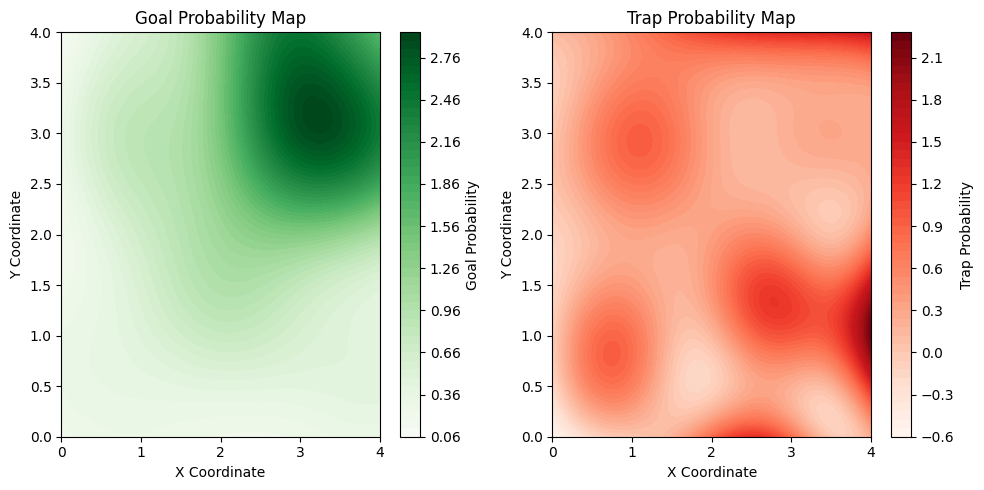